In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
path = '/content/drive/My Drive/MyFolder/cleaned_marketing.csv'
data = pd.read_csv(path)

In [ ]:
data.rename({'Year_Birth': 'Age'}, axis=1, inplace=True)

In [ ]:
data.columns

Index(['ID', 'Age', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'TotalAmount', 'IncomeCat'],
      dtype='object')

In [ ]:
data['NumInteract'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases'] + data['NumWebVisitsMonth']

In [ ]:
people_list = ['ID', 'Age', 'Education', 'Marital_Status', 'Income', 'IncomeCat',
               'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'Complain']
product_list = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                'MntSweetProducts', 'MntGoldProds', 'TotalAmount']
promotion_list = ['NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2',
                  'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
place_list = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
              'NumWebVisitsMonth', 'NumInteract']

# RFM analysis

In [ ]:
RM_data = data[['ID', 'Recency', 'NumInteract', 'TotalAmount']].copy()

In [ ]:
def cal_score(n, min, max, scale=10):
    size = (max - min) / scale
    score = int((n - min) / size)
    if score == scale:
        score -= 1
    return score

In [ ]:
def cal_score_series(ser, scale=10):
    min = ser.min()
    max = ser.max()
    ser_score = ser.apply(lambda x: cal_score(x, min, max, scale))
    return ser_score

In [ ]:
RM_data['R_score'] = 9 - cal_score_series(RM_data['Recency'])
RM_data['F_score'] = cal_score_series(RM_data['NumInteract'])
RM_data['M_score'] = cal_score_series(RM_data['TotalAmount'])
RM_data['score'] = RM_data['R_score'] + RM_data['F_score'] + RM_data['M_score']

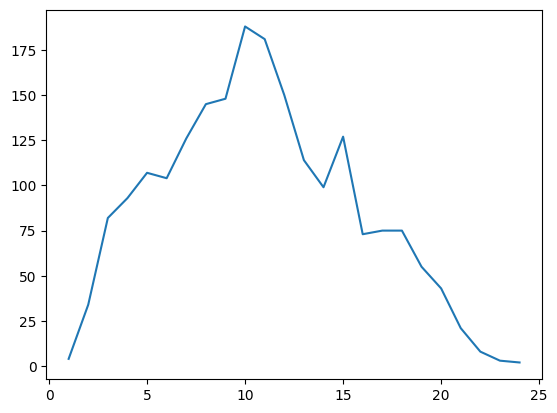

In [ ]:
RM_data['score'].value_counts().sort_index().plot()
plt.show()

In [ ]:
# assign the scores
data['RM_score'] = RM_data['score']

# k-means

first combination

In [ ]:
comb_data = data[['Income', 'TotalAmount']].copy()

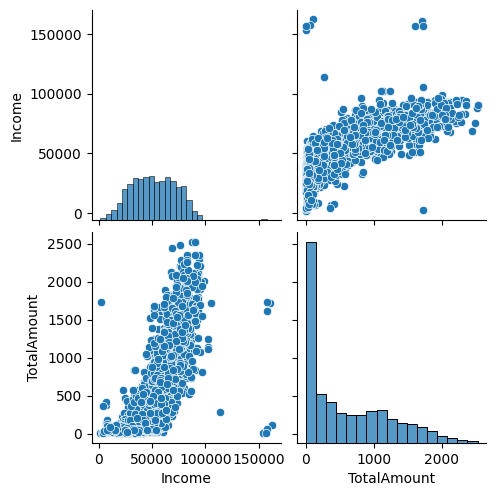

In [ ]:
sns.pairplot(comb_data)
plt.show()

In [ ]:
std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(np.log(comb_data))

In [ ]:
wcss = []
sil_score = []
sil_samples = []
for k in range(2, 11):
    # learning
    kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++', random_state=0)
    cluster_label = kmeans.fit_predict(std_data)
    # calculating
    wcss.append(kmeans.inertia_)
    sil_avg = silhouette_score(std_data, cluster_label)
    sil_score.append(sil_avg)
    sil_sample = silhouette_samples(std_data, cluster_label)
    sil_sample_with_label = np.vstack((sil_sample, cluster_label))
    sil_samples.append(sil_sample_with_label)

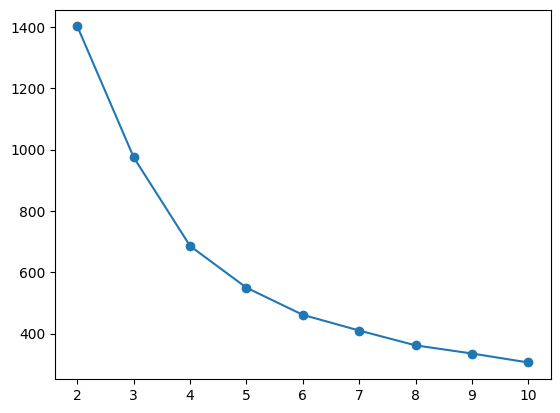

In [ ]:
plt.plot(list(range(2, 11)), wcss, 'o-')
plt.xticks(list(range(2, 11)))
plt.show()

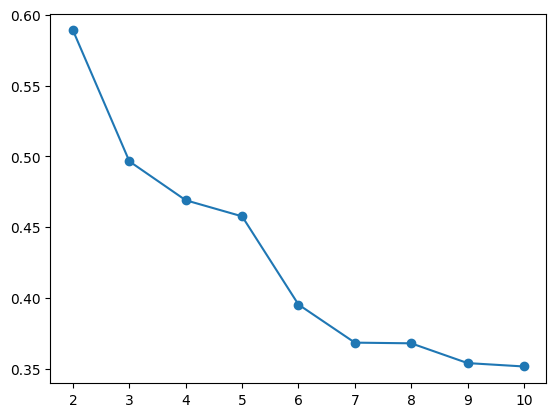

In [ ]:
plt.plot(list(range(2, 11)), sil_score, 'o-')
plt.xticks(list(range(2, 11)))
plt.show()

In [ ]:
def sil_diagram_draw(scores, sample_scores, n_clusters):
    #initial objects
    index = n_clusters - 2
    sil_sample_score = sample_scores[index][0].copy()
    sample_label = sample_scores[index][1].copy()
    fig, ax = plt.subplots()
    y_lower = 10
    for i in range(n_clusters):
        cluster_indice = (sample_label == i)
        cluster_sil_values = sil_sample_score[cluster_indice]
        cluster_sil_values.sort()
        size = cluster_sil_values.shape[0]
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(i) / 4)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper), 0, cluster_sil_values,
            facecolor=color, edgecolor=color, alpha=0.7,
        )
        ax.text(-0.05, y_lower + 0.5 * size, str(i))
        y_lower = y_upper + 10

    ax.axvline(x=scores[index], color="red", linestyle="--")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.set_yticks([])
    return ax

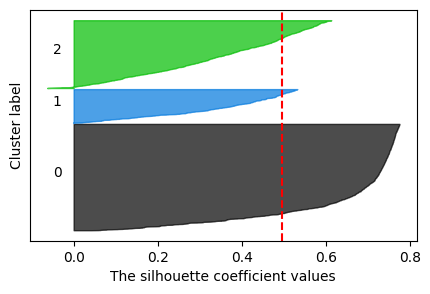

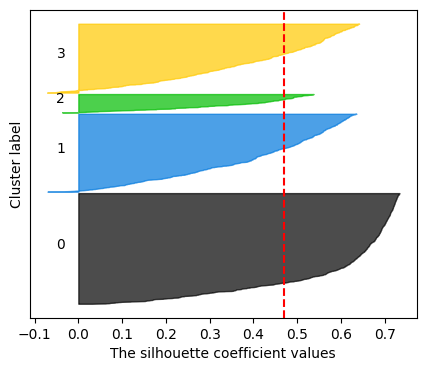

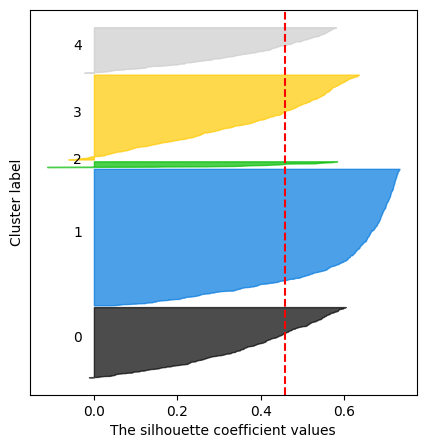

In [ ]:
sil_diagram_draw(sil_score, sil_samples, 3)
sil_diagram_draw(sil_score, sil_samples, 4)
sil_diagram_draw(sil_score, sil_samples, 5)
plt.show()

In [ ]:
# choose 4 as parameter
kmeans = KMeans(n_clusters=4, n_init=10, init='k-means++', random_state=0)
cluster_label = kmeans.fit_predict(std_data)

In [ ]:
comb_data['label'] = cluster_label

<Axes: xlabel='Income', ylabel='TotalAmount'>

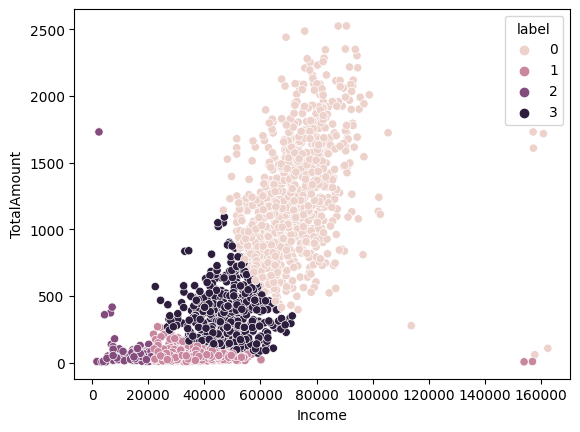

In [ ]:
sns.scatterplot(x='Income', y='TotalAmount', data=comb_data, hue='label')

In [ ]:
# assign the labels
data['first_label'] = cluster_label

second combination

In [ ]:
second_comb_data = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                         'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
                         'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']].copy()

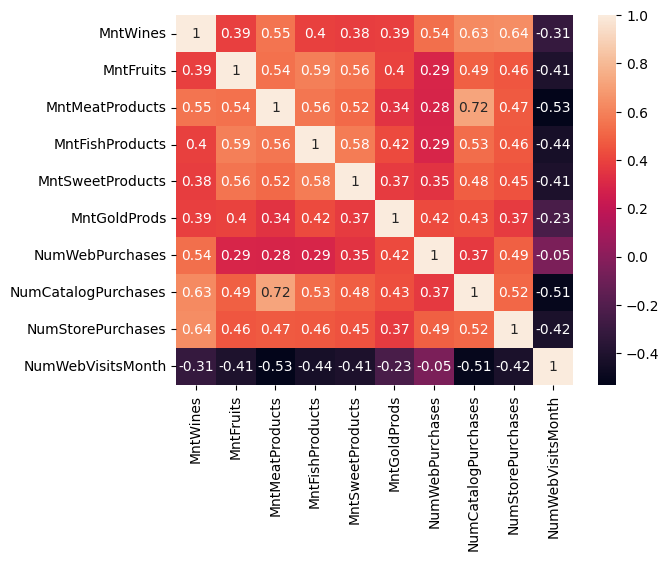

In [ ]:
sns.heatmap(second_comb_data.corr(), annot=True)
plt.show()

In [ ]:
# exclude zeros
second_comb_data += 1
# transform
std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(np.log(second_comb_data))

In [ ]:
wcss = []
sil_score = []
sil_samples = []
for k in range(2, 11):
    # learning
    kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++', random_state=0)
    cluster_label = kmeans.fit_predict(std_data)
    # calculating
    wcss.append(kmeans.inertia_)
    sil_avg = silhouette_score(std_data, cluster_label)
    sil_score.append(sil_avg)
    sil_sample = silhouette_samples(std_data, cluster_label)
    sil_sample_with_label = np.vstack((sil_sample, cluster_label))
    sil_samples.append(sil_sample_with_label)

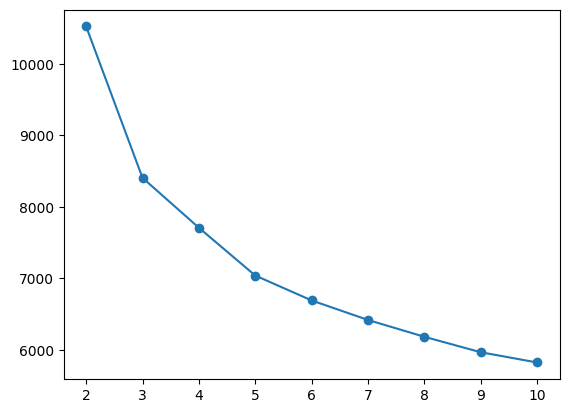

In [ ]:
plt.plot(list(range(2, 11)), wcss, 'o-')
plt.xticks(list(range(2, 11)))
plt.show()

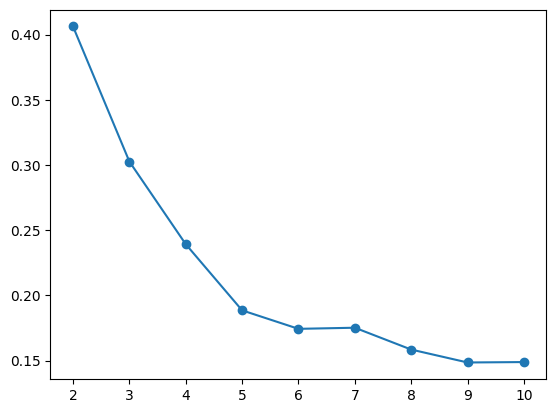

In [ ]:
plt.plot(list(range(2, 11)), sil_score, 'o-')
plt.xticks(list(range(2, 11)))
plt.show()
# bad values, reject this combination

Automated selecting with PCA

In [ ]:
data.columns

Index(['ID', 'Age', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'TotalAmount', 'IncomeCat',
       'RM_score', 'first_label'],
      dtype='object')

In [ ]:
selected_cols = ['Marital_Status', 'Income', 'Kidhome', 'Recency', 'MntWines',
                 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
                 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
selected_data = data[selected_cols].copy()

In [ ]:
std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(selected_data)

In [ ]:
var_ratio = []
for i in range(std_data.shape[1]):
    pca = PCA(n_components=i)
    pca.fit(std_data)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

Text(0, 0.5, 'Explained variance ratio')

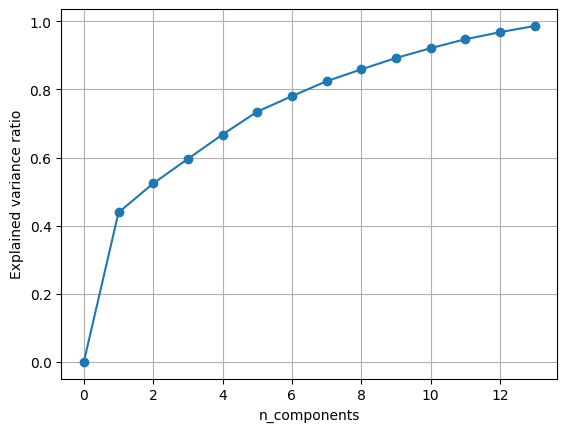

In [ ]:
plt.grid()
plt.plot(list(range(std_data.shape[1])), var_ratio, 'o-')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.show()

In [ ]:
# choose 7 as likely parameter
pca = PCA(n_components=7)
std_data = pca.fit_transform(std_data)

In [ ]:
std_data_backup = std_data.copy()

In [ ]:
wcss = []
sil_score = []
sil_samples = []
for k in range(2, 11):
    # learning
    kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++', random_state=0)
    cluster_label = kmeans.fit_predict(std_data)
    # calculating
    wcss.append(kmeans.inertia_)
    sil_avg = silhouette_score(std_data, cluster_label)
    sil_score.append(sil_avg)
    sil_sample = silhouette_samples(std_data, cluster_label)
    sil_sample_with_label = np.vstack((sil_sample, cluster_label))
    sil_samples.append(sil_sample_with_label)

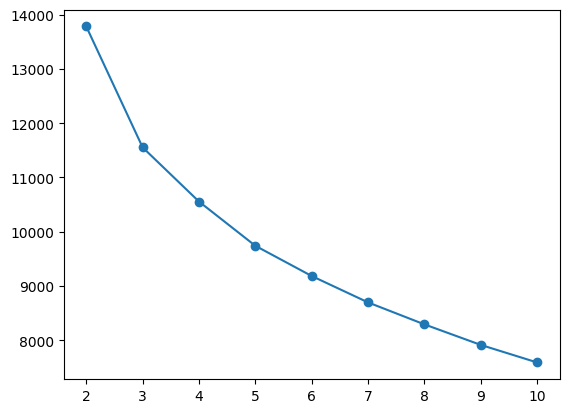

In [ ]:
plt.plot(list(range(2, 11)), wcss, 'o-')
plt.xticks(list(range(2, 11)))
plt.show()

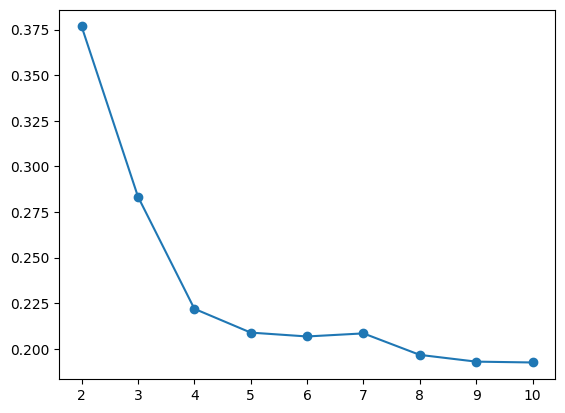

In [ ]:
plt.plot(list(range(2, 11)), sil_score, 'o-')
plt.xticks(list(range(2, 11)))
plt.show()
# low silhouette values, reject this approach

# Gaussian mixture for generative model

In [ ]:
bic = []
aic = []
for k in range(2, 11):
    gm = GaussianMixture(n_components=k, n_init=10)
    gm.fit(std_data)
    bic.append(gm.bic(std_data))
    aic.append(gm.aic(std_data))

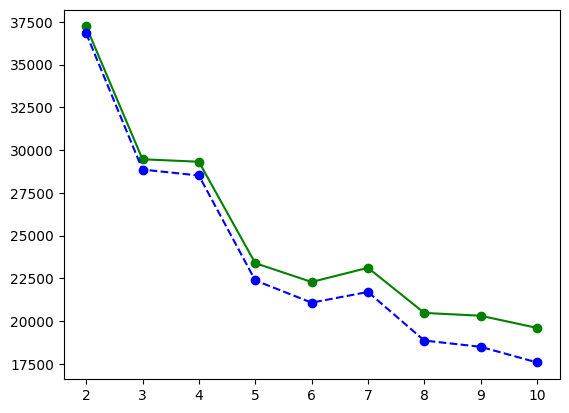

In [ ]:
plt.plot(list(range(2, 11)), bic, 'o-', c='g')
plt.plot(list(range(2, 11)), aic, 'o--', c='b')
plt.xticks(list(range(2, 11)))
plt.show()

In [ ]:
# apply for 5 components
gm = GaussianMixture(n_components=5, n_init=5)
gm.fit(std_data)

GaussianMixture(n_components=5, n_init=5)

In [ ]:
data['gmm_label'] = gm.predict(std_data)

# Compare the labels

In [ ]:
data['first_label'].value_counts()

0    825
1    581
3    514
2    137
Name: first_label, dtype: int64

In [ ]:
data['gmm_label'].value_counts()

2    715
0    396
1    363
3    333
4    250
Name: gmm_label, dtype: int64

### k-means labelling

In [ ]:
data.groupby('first_label')['Education'].value_counts().unstack(level=-1)

Education,Graduation,Postgraduation,Undergraduation
first_label,,,
0,428,329,68
1,287,208,86
2,62,26,49
3,252,228,34


In [ ]:
data.groupby('first_label')['Education'].value_counts(normalize=True).unstack(level=-1)

Education,Graduation,Postgraduation,Undergraduation
first_label,,,
0,0.518788,0.398788,0.082424
1,0.493976,0.358003,0.148021
2,0.452555,0.189781,0.357664
3,0.490272,0.443580,0.066148


In [ ]:
data.groupby('first_label')[['Income', 'Kidhome']].agg(['mean', 'median', 'min', 'max'])

Income                               Kidhome               
                     mean   median      min       max      mean median min max
first_label                                                                   
0            72502.947879  71604.0  46757.0  162397.0  0.087273    0.0   0   2
1            34743.877797  33569.0  21645.0  156924.0  0.864028    1.0   0   2
2            15080.000000  16531.0   1730.0   21474.0  0.729927    1.0   0   2
3            48635.589494  49176.5  22507.0   71322.0  0.470817    0.0   0   2

In [ ]:
data.groupby('first_label')[product_list].mean()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmount
first_label,,,,,,,
0,618.992727,53.641212,358.186667,75.797576,55.212121,72.814545,1234.644848
1,21.523236,3.297762,14.561102,4.557659,3.456110,10.266781,57.662651
2,9.284672,5.591241,24.321168,7.262774,5.452555,19.781022,71.693431
3,196.529183,13.698444,73.583658,20.700389,14.832685,41.891051,361.235409


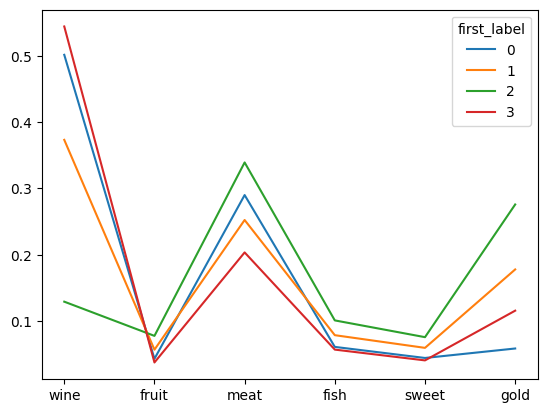

In [ ]:
temp = data.groupby('first_label')[product_list].mean()
temp = temp.div(temp['TotalAmount'], axis=0).drop('TotalAmount', axis=1)

ax = temp.T.plot()
ax.set_xticks(np.arange(6))
ax.set_xticklabels(['wine', 'fruit', 'meat', 'fish', 'sweet', 'gold'])
plt.show()

In [ ]:
data.groupby('first_label')[place_list].mean()

,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,NumInteract
first_label,,,,,
0,5.733333,5.210909,8.516364,3.767273,23.227879
1,1.654045,0.296041,2.879518,6.375215,11.204819
2,2.065693,0.635036,2.605839,7.562044,12.868613
3,4.782101,1.784047,5.480545,6.019455,18.066148


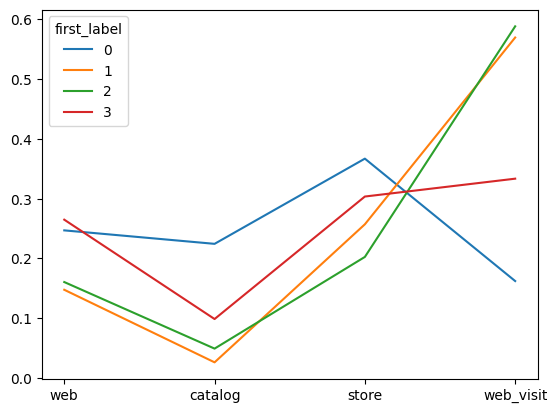

In [ ]:
temp = data.groupby('first_label')[place_list].mean()
temp = temp.div(temp['NumInteract'], axis=0).drop('NumInteract', axis=1)

ax = temp.T.plot()
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['web', 'catalog', 'store', 'web_visit'])
plt.show()

In [ ]:
data.groupby('first_label')['RM_score'].agg(['mean', 'min', 'max'])

,mean,min,max
first_label,,,
0,14.584242,5,24
1,6.984509,1,14
2,7.591241,2,18
3,9.667315,2,19


### GMM labelling with PCA

In [ ]:
data.groupby('gmm_label')['Education'].value_counts().unstack(level=-1)

Education,Graduation,Postgraduation,Undergraduation
gmm_label,,,
0,186,158,52
1,162,171,30
2,340,278,97
3,216,80,37
4,125,104,21


In [ ]:
data.groupby('gmm_label')['Education'].value_counts(normalize=True).unstack(level=-1)

Education,Graduation,Postgraduation,Undergraduation
gmm_label,,,
0,0.469697,0.398990,0.131313
1,0.446281,0.471074,0.082645
2,0.475524,0.388811,0.135664
3,0.648649,0.240240,0.111111
4,0.500000,0.416000,0.084000


In [ ]:
data.groupby('gmm_label')[['Income', 'Kidhome']].agg(['mean', 'median', 'min', 'max'])

Income                              Kidhome               
                   mean   median     min       max      mean median min max
gmm_label                                                                  
0          37904.785354  37894.0  3502.0   69263.0  0.714646    1.0   0   2
1          74435.371901  73691.0  2447.0  162397.0  0.008264    0.0   0   1
2          38347.542657  37717.0  7500.0   77622.0  0.716084    1.0   0   2
3          71529.231231  72354.0  4428.0  105471.0  0.090090    0.0   0   1
4          55190.864000  57103.5  1730.0   89891.0  0.352000    0.0   0   2

In [ ]:
data.groupby('gmm_label')[product_list].mean()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmount
gmm_label,,,,,,,
0,93.823232,5.169192,31.588384,6.739899,4.696970,17.982323,160.000000
1,560.451791,45.471074,379.060606,66.030303,50.203857,34.980716,1136.198347
2,101.134266,4.696503,31.864336,6.851748,4.944056,15.779021,165.269930
3,559.783784,80.624625,410.453453,114.576577,82.381381,117.669670,1365.489489
4,504.580000,20.872000,142.184000,28.500000,19.508000,79.976000,795.620000


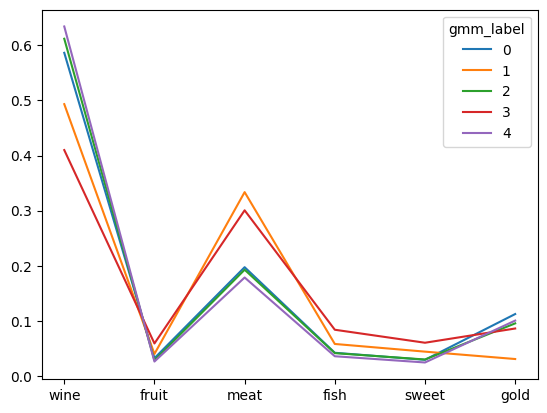

In [ ]:
temp = data.groupby('gmm_label')[product_list].mean()
temp = temp.div(temp['TotalAmount'], axis=0).drop('TotalAmount', axis=1)

ax = temp.T.plot()
ax.set_xticks(np.arange(6))
ax.set_xticklabels(['wine', 'fruit', 'meat', 'fish', 'sweet', 'gold'])
plt.show()

In [ ]:
data.groupby('gmm_label')[place_list].mean()

,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,NumInteract
gmm_label,,,,,
0,2.820707,0.787879,3.737374,6.391414,13.737374
1,4.917355,5.179063,8.504132,2.815427,21.415978
2,2.843357,0.755245,3.941259,6.327273,13.867133
3,5.846847,5.738739,8.111111,3.579580,23.276276
4,6.200000,3.328000,7.148000,6.692000,23.368000


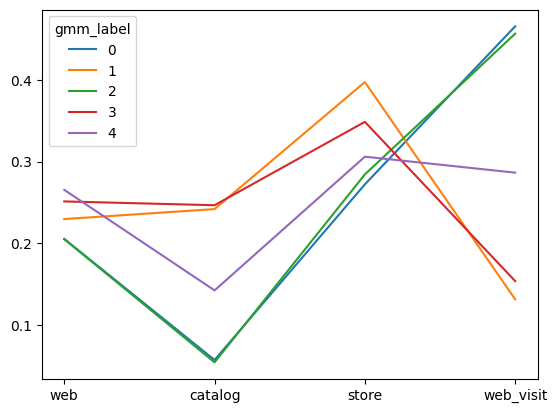

In [ ]:
temp = data.groupby('gmm_label')[place_list].mean()
temp = temp.div(temp['NumInteract'], axis=0).drop('NumInteract', axis=1)

ax = temp.T.plot()
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['web', 'catalog', 'store', 'web_visit'])
plt.show()

In [ ]:
data.groupby('gmm_label')['RM_score'].agg(['mean', 'min', 'max'])

,mean,min,max
gmm_label,,,
0,8.063131,2,17
1,13.840220,1,24
2,7.924476,1,18
3,14.519520,5,22
4,13.524000,3,24
